**Project Aim**

* The aim of this project is to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. 

**Data**
* The anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column.

In [39]:
import gc
import os
import logging
import datetime
import warnings
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [3]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
x = train_df.drop(['ID_code', 'target'], axis=1)
y = train_df['target']
x_test = test_df.drop(['ID_code'], axis =1)

In [6]:
x.shape, x_test.shape, y.shape

((200000, 200), (200000, 200), (200000,))

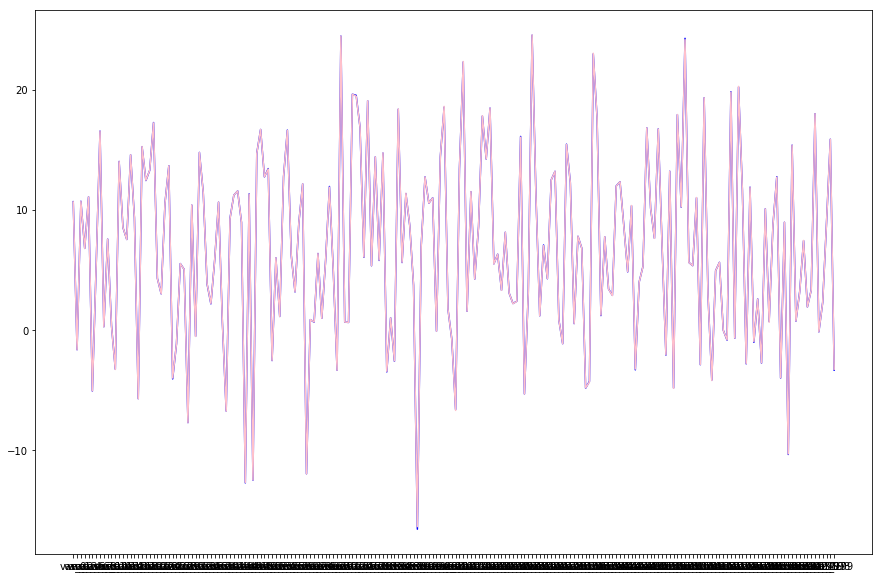

In [7]:
mean_train = x.mean()
mean_test = x_test.mean()
plt.figure(figsize=(15,10))
plt.plot(mean_train, color='blue')
plt.plot(mean_test, color = 'pink')
plt.show();

In [8]:
pd.DataFrame([mean_test, mean_train])

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,0.371335,-3.268551,14.022662,8.540872,7.532703,14.573704,9.321669,-5.704450,15.265776,12.456675,13.298428,17.230598,4.29901,3.019707,10.567479,13.666970,-3.983721,-1.129536,5.530656,5.047247,-7.687695,10.404920,-0.524830,14.762686,11.434861,3.870130,2.213288,5.875048,10.647806,0.672667,...,24.146181,5.635300,5.360975,11.026376,-2.857328,19.320760,2.962821,-4.189133,4.930356,5.633716,-0.020824,-0.805148,19.779528,-0.666240,20.264135,11.635715,-2.776134,11.864538,-0.949318,2.582604,-2.722636,10.080827,0.651432,8.768929,12.719302,-3.963045,8.978800,-10.291919,15.366094,0.755673,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
1,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.30543,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,0.662956,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537


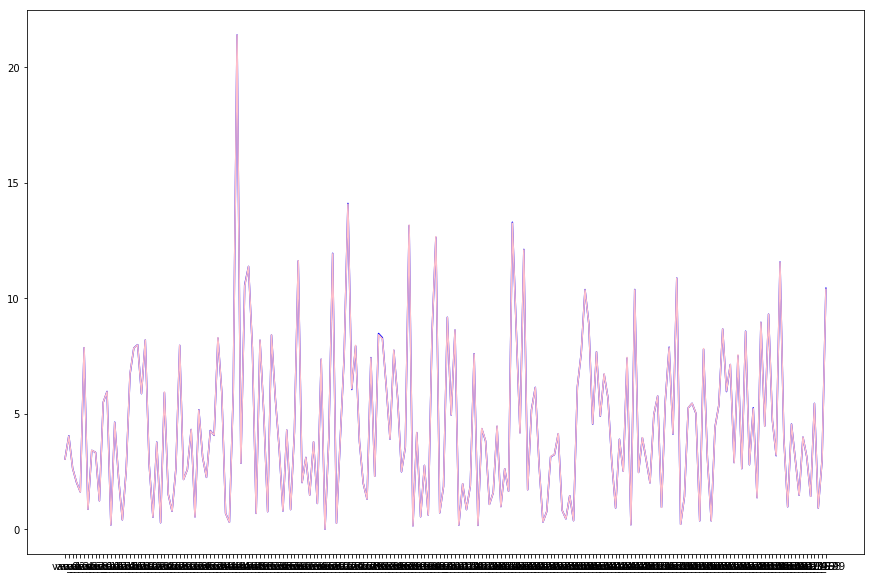

In [9]:
std_train = x.std()
std_test = x_test.std()
plt.figure(figsize=(15,10))
plt.plot(std_train, color='blue')
plt.plot(std_test, color = 'pink')
plt.show();

In [10]:
pd.DataFrame([std_test, std_train])

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,5.508661,5.961443,0.190071,4.628712,2.255257,0.411592,2.544860,6.746460,7.846983,7.989812,5.884245,8.199877,2.844023,0.527951,3.771047,0.285454,5.945853,1.524765,0.785618,2.610078,7.971581,2.156324,2.58870,4.325727,0.541040,5.170614,3.120685,2.257235,4.260820,4.078592,...,10.876184,0.217936,1.426064,5.268894,5.457937,5.039303,0.370668,7.827428,3.086443,0.365750,4.417876,5.378492,8.678024,5.987419,7.141816,2.884821,7.557001,2.626556,8.570314,2.803890,5.225554,1.369546,8.961936,4.464461,9.316889,4.724641,3.206635,11.562352,3.929227,0.976123,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
1,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.58783,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,4.068845,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015


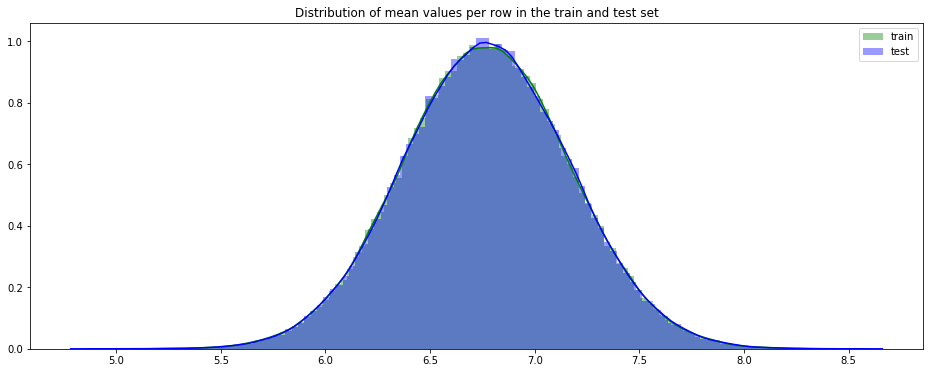

In [11]:
#Mean Distribution

plt.figure(figsize=(16,6))
features = x.columns
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(x[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(x_test[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show();

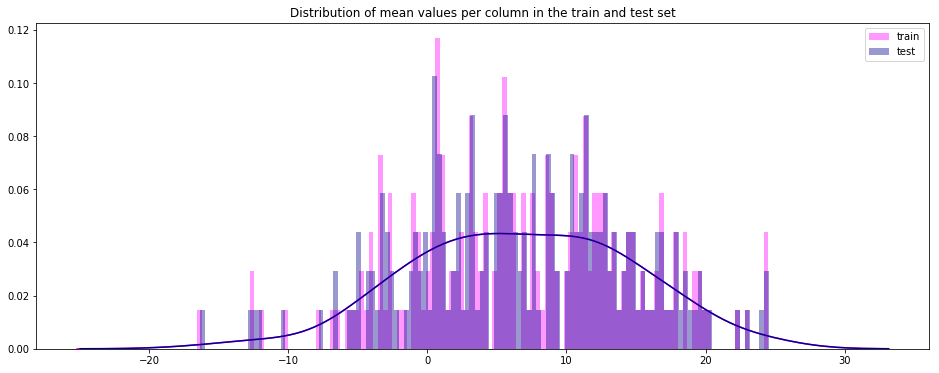

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(x[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(x_test[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

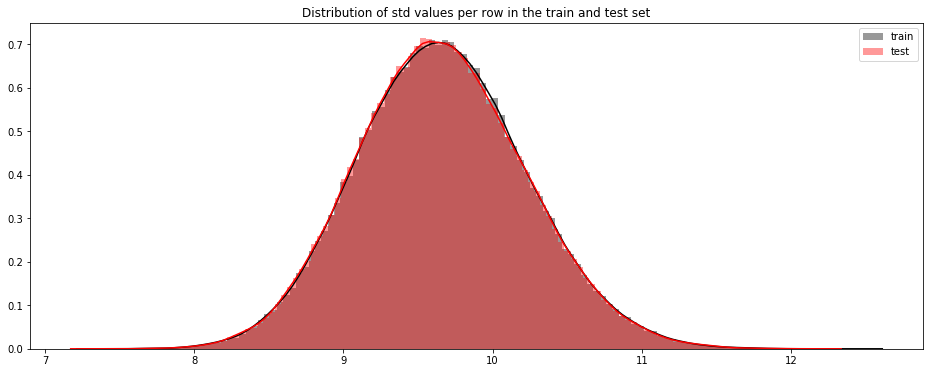

In [13]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(x[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(x_test[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();
plt.show();

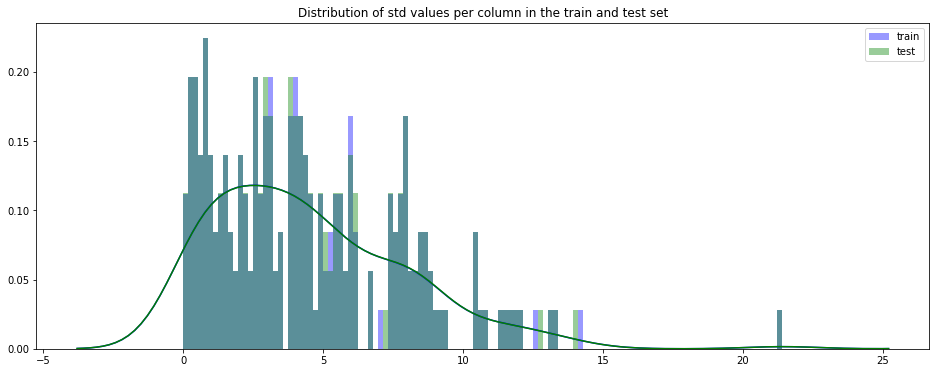

In [14]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(x[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(x_test[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

In [15]:
%%time
correlations = x[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

CPU times: user 18.7 s, sys: 184 ms, total: 18.9 s
Wall time: 18.9 s


In [16]:
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


In [17]:
gc.collect()

15226

In [18]:
x_test = (x_test - mean_test) + (mean_train)
x_test = x_test / (std_train)
x = x / (std_train)

In [19]:
#features

In [20]:
for df in [x, x_test]:
        for feat in features:
            df['r2_'+feat] = np.round(df[feat], 2)
            df['r2_'+feat] = np.round(df[feat], 2)
            
        df['sum'] = df[features].sum(axis=1)  
        df['min'] = df[features].min(axis=1)
        df['max'] = df[features].max(axis=1)
        df['mean'] = df[features].mean(axis=1)
        df['std'] = df[features].std(axis=1)
        df['skew'] = df[features].skew(axis=1)
        df['kurt'] = df[features].kurtosis(axis=1)
        df['med'] = df[features].median(axis=1)
print('Train and test shape:',x.shape, x_test.shape)

Train and test shape: (200000, 408) (200000, 408)


In [22]:
model = ExtraTreesClassifier()
model.fit(x,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [23]:
impotrant_featues = {}
for i, j in enumerate(model.feature_importances_):
    impotrant_featues[i] = j

In [26]:
variables = [k for k in sorted(impotrant_featues, key=impotrant_featues.get, reverse=True)][:50]

In [34]:
imp_features = []
for var in variables:
    if var <200:
        imp_features.append("var_"+str(var))

In [35]:
train_df[imp_features].shape

(200000, 26)

In [40]:
def dist(a,b):
    return distance.euclidean(a, b)

for i in imp_features:
    
    mean_1 = train_df[i][train_df['target']==1].mean()
    mean_0 = train_df[i][train_df['target']==0].mean()
    
    mean_1_col =  i + "_mean_1_dist"
    mean_0_col =  i + "_mean_0_dist"
    
    x[mean_1_col] = x.apply(lambda p: dist(p[i], mean_1), axis=1)
    x[mean_0_col] = x.apply(lambda p: dist(p[i], mean_0), axis=1)
    
    x_test[mean_1_col] = x_test.apply(lambda x: dist(x[i], mean_1), axis=1)
    x_test[mean_0_col] = x_test.apply(lambda x: dist(x[i], mean_0), axis=1)
    
    print("done ",i)

done  var_81
done  var_6
done  var_139
done  var_12
done  var_146
done  var_26
done  var_53
done  var_174
done  var_80
done  var_99
done  var_110
done  var_109
done  var_76
done  var_22
done  var_2
done  var_165
done  var_13
done  var_44
done  var_179
done  var_190
done  var_78
done  var_1
done  var_148
done  var_133
done  var_0
done  var_184


In [41]:
x.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_53_mean_1_dist,var_53_mean_0_dist,var_174_mean_1_dist,var_174_mean_0_dist,var_80_mean_1_dist,var_80_mean_0_dist,var_99_mean_1_dist,var_99_mean_0_dist,var_110_mean_1_dist,var_110_mean_0_dist,var_109_mean_1_dist,var_109_mean_0_dist,var_76_mean_1_dist,var_76_mean_0_dist,var_22_mean_1_dist,var_22_mean_0_dist,var_2_mean_1_dist,var_2_mean_0_dist,var_165_mean_1_dist,var_165_mean_0_dist,var_13_mean_1_dist,var_13_mean_0_dist,var_44_mean_1_dist,var_44_mean_0_dist,var_179_mean_1_dist,var_179_mean_0_dist,var_190_mean_1_dist,var_190_mean_0_dist,var_78_mean_1_dist,var_78_mean_0_dist,var_1_mean_1_dist,var_1_mean_0_dist,var_148_mean_1_dist,var_148_mean_0_dist,var_133_mean_1_dist,var_133_mean_0_dist,var_0_mean_1_dist,var_0_mean_0_dist,var_184_mean_1_dist,var_184_mean_0_dist
0,2.935971,-1.675611,4.509117,2.492513,7.060779,-1.180603,5.906597,5.449441,-1.476310,4.653178,0.531778,0.532992,73.733329,0.123827,3.914261,35.386679,2.247850,-1.078462,0.545637,3.840750,1.792809,1.978768,0.905596,4.690891,3.807828,47.043194,-0.869405,-0.267307,6.294110,2.292291,-0.038731,5.974423,-1.498012,3.907874,20.664156,2.042355,0.216796,3.505799,1.090630,0.952187,...,0.611434,0.772697,16.292978,17.756781,2.678201,4.103188,1.411495,1.049910,5.716896,4.899539,12.213334,12.936524,4.875583,6.510433,3.915833,3.342189,6.647516,6.156759,15.957295,16.888657,7.640791,8.491937,6.110038,7.072886,2.395576,1.930080,3.025372,2.176438,2.367165,2.047229,0.657999,0.020158,16.267721,16.231274,10.610359,10.678505,8.220447,7.690710,11.330636,9.833174
1,3.783029,-1.024014,5.247768,2.637376,7.616181,0.895722,6.485983,4.837166,0.944238,6.546269,-0.073299,1.349775,73.786997,1.813436,2.417581,33.276463,5.406814,-2.321734,0.993457,3.572827,0.583484,0.334372,3.002994,6.399017,1.847352,48.648949,-1.987164,-1.679186,6.441934,0.209523,-1.167416,3.646249,0.496903,4.481616,20.993172,0.142850,0.897282,2.597378,2.527751,0.904016,...,2.592335,2.753598,14.653123,16.116926,4.170872,5.595859,0.793601,1.155185,4.516871,3.699514,14.802730,15.525920,4.168270,5.803120,1.818435,1.244791,5.908865,5.418108,15.465653,16.397015,5.951182,6.802328,7.871392,8.834240,0.946741,1.412237,2.322136,1.473203,2.874941,2.555005,0.006401,0.671756,17.417363,17.380916,11.898686,11.966832,7.373389,6.843652,11.684317,10.186855
2,2.831959,-0.677943,4.574398,3.862735,6.519732,-1.155207,8.011357,4.275944,-1.476100,4.819565,-0.059064,-1.886821,74.676193,1.576106,3.347290,35.576375,3.002321,-0.259139,0.598762,2.560746,3.021636,2.212842,0.426446,6.668711,1.503132,46.290923,-1.349834,-1.905147,7.463038,2.348638,-1.393876,5.780756,-0.883791,4.405546,20.392560,0.793253,1.505588,3.082415,2.545442,0.221267,...,2.222804,2.384067,15.295251,16.759055,3.508391,4.933378,0.406605,0.768189,5.403524,4.586167,13.125956,13.849146,4.012834,5.647685,4.394983,3.821339,6.582235,6.091478,14.395887,15.327249,6.188512,7.039658,7.387542,8.350390,2.152235,1.686739,3.360838,2.511905,2.467878,2.147941,0.339670,1.017826,16.481584,16.445138,10.758654,10.826800,8.324459,7.794722,11.626099,10.128636
3,3.638229,-0.531303,3.389837,3.521574,7.753198,-0.233503,6.742154,4.366492,-1.758639,6.675735,0.419230,0.470700,72.852551,2.580086,2.872404,36.037863,4.200716,-0.064044,2.030550,1.716422,3.454752,1.532093,2.394769,5.167838,3.212765,48.108560,0.137364,-0.594534,7.540524,1.085919,-1.913298,4.833902,-0.994308,1.429694,19.588297,-1.142144,2.619346,1.267752,2.143961,0.163806,...,0.657854,0.819117,16.827349,18.291152,4.407844,5.832831,1.466925,1.828510,5.128287,4.310930,14.497864,15.221054,3.108024,4.742875,2.426661,1.853016,7.766796,7.276039,15.044550,15.975911,5.184532,6.035678,6.718755,7.681603,0.975082,0.509586,3.018530,2.169596,3.590613,3.270676,0.486310,1.164467,14.924799,14.888352,12.282335,12

In [ ]:
 param = {
        'bagging_freq': 5,
        'bagging_fraction': 0.38,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.045,
        'learning_rate': 0.0095,
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 13,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'binary', 
        'verbosity': 1,
         'lambda_l1': 4.972,
        'lambda_l2': 2.276,
         'is_unbalance': True
    }

In [ ]:
param = {'max_depth': 3, 
         'num_leaves': 6, 
         'min_child_samples': 200, 
         'scale_pos_weight': 1.0, 
         'subsample': 0.6, 
         'colsample_bytree': 0.6, 
         'metric': 'auc', 
         'nthread': 8, 
         'boosting_type': 'gbdt', 
         'objective': 'binary', 
         'learning_rate': 0.15, 
         'max_bin': 100, 
         'min_child_weight': 0, 
         'min_split_gain': 0, 
         'subsample_freq': 1,
         'is_unbalance': True,
        'bagging_freq': 5,
        'bagging_fraction': 0.38,
        'boost_from_average':'false',
          'feature_fraction': 0.045,
        'learning_rate': 0.0095,
         'min_data_in_leaf': 80,
        'min_sum_hessian_in_leaf': 10.0,
         'tree_learner': 'serial'}

In [ ]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}
gc.collect()

In [ ]:
nfold = 5 #5
k =StratifiedKFold(n_splits=nfold, shuffle=True, random_state=49)
#k = RepeatedStratifiedKFold(n_splits = nfold, n_repeats=5, random_state=49)
oof = np.zeros(len(y))
predictions = np.zeros(len(x_test))

i =1

for train_idx, val_idx in k.split(x, y.values):
    print("\n fold {}".format(i))
    
    light_train = lightgbm.Dataset(x.iloc[train_idx].values,
                                  label = y.iloc[train_idx].values,
                                  free_raw_data = False)
    light_val = lightgbm.Dataset(x.iloc[val_idx].values,
                                label = y.iloc[val_idx].values,
                                free_raw_data = False)
    
    clf = lightgbm.train(param, light_train, 9000, valid_sets=[light_val], verbose_eval=200, early_stopping_rounds=100)
    
    oof[val_idx] = clf.predict(x.iloc[val_idx].values, num_iteration = clf.best_iteration)
    
    predictions += clf.predict(x_test.values, num_iteration= clf.best_iteration) /nfold
    
    i+=1

In [ ]:
print("CV AUC: {:<0.2f}".format(metrics.roc_auc_score(y.values, oof)))

In [ ]:
sub_df = pd.DataFrame()
sub_df['ID_code'] = test_df['ID_code']
sub_df['target'] = predictions
sub_df.to_csv("sub1.csv", index = False)